# To be able to see maps in this notebook, please follow this [link](http://nbviewer.jupyter.org/github/antonino-barbera/seanbi/blob/master/project/project.ipynb?flush_cache=true)

# Data Collection

We will analyse data which comprise detail information on almost 3 million U.S. patents granted between January 1963 and December 1999. The patent dataset is maintained by the National Bureau of Economic Research (NBER). We downloaded them at the following link: http://www.nber.org/patents/

The data are in 5 zipped ASCII CSV files as follows:

* Pat63_99.zip contains the patent data, including the constructed variables
* Coname.zip contains the assignee names.
* Match.zip contains the match to CUSIP numbers
* Inventor.zip contains the individual inventor records
* Cite75_99.zip contains the pairwise citations data, between 1975 and 1999.

Each of these files has a corresponding "txt" file that contains the variable names and other documentation.

These data are described in detail in NBER Working Paper No. XXXX, "The NBER Patent Citations Data File:  Lessons, Insights and Methodological Tools," by Bronwyn H. Hall, Adam B. Jaffe and Manuel Trajtenberg.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import seaborn as sbn
import folium
import json
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import networkx as nx
init_notebook_mode(connected=True)

### Pat63_99 file

In [2]:
df = pd.read_csv('data/apat63_99.csv')
print ("lenght: ",len(df))
df.head()

lenght:  2923922


,PATENT,GYEAR,GDATE,APPYEAR,COUNTRY,POSTATE,ASSIGNEE,ASSCODE,CLAIMS,NCLASS,...,CRECEIVE,RATIOCIT,GENERAL,ORIGINAL,FWDAPLAG,BCKGTLAG,SELFCTUB,SELFCTLB,SECDUPBD,SECDLWBD
0,3070801,1963,1096,NaN,BE,NaN,NaN,1,NaN,269,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3070802,1963,1096,NaN,US,TX,NaN,1,NaN,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3070803,1963,1096,NaN,US,IL,NaN,1,NaN,2,...,9,NaN,0.3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3070804,1963,1096,NaN,US,OH,NaN,1,NaN,2,...,3,NaN,0.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3070805,1963,1096,NaN,US,CA,NaN,1,NaN,2,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Pat63_99 file is sorted by ascending patent number. <br>
There are 23 variables, which represent the following characteristics:
------------------

    patent: Patent Number
    gyear: Grant Year
    gdate: Grant Date
    appyear: Application Year
    country: Country of First Inventor
    postate: State of First Inventor (if US)
    assignee: Assignee Identifier (missing 1963-1967)
    asscode: Assignee Type
    claims: number of Claims
    nclass: Main Patent Class (3 digit)
    cat: Technological Category
    subcat: Technological Sub-Category
    cmade: Number of Citations Made
    creceive: Number of Citations Received
    ratiocit: Percent of Citations Made to Patents Granted Since 1963
    general: Measure of Generality
    original: Measure of Originality
    fwdaplag: Mean Forward Citation Lag
    bckgtlag: Mean Backward Citation Lag
    selfctub: Share of Self-Citations Made - Upper Bound
    selfctlb: Share of Self-Citations Made - Lower Bound
    secdupbd: Share of Self-Citations Received - Upper Bound
    secdlwbd: Share of Self-Citations Received - Lower Bound

**More useful information about the variables:**

1. The State/Country Code is a three-character code. A list of corresponding state and country
   names is included in the list_countries file in nber page. These codes are present for all patents in the file 
   (1963-1999).
2. The Assignee Identifier can be converted to the company name using the Coname file, 
   Assignee Identifier is available for patents granted since 1969. 
3. The Assignee type code is a one-character code having the following meaning:

     1    = unassigned
     2    = assigned to a U.S. nongovernment organization
     3    = assigned to a non-U.S., nongovernment organization
     4    = assigned to a U.S. individual
     5    = assigned to a non-U.S. individual
     6    = assigned to the U.S. (Federal) Government
     7    = assigned to a non-U.S. government
     8,9  = assigned to a U.S. non-Federal Government agency (do not appear in the dataset)
                 
4. The upper and lower bound for self-citations, together with the number of citations received,
   allow to compute the number of citations received having an assignee identifier (same for 
   citations made).
5. The application year is available for patents granted since 1967.
6. The number of claims is available for patents granted since 1975.
7. Grant Date is the number of days elapsed since 1.1.1960.

In [3]:
num_valid_entries_per_column = df.count(axis=0)
print (num_valid_entries_per_column)

PATENT      2923922
GYEAR       2923922
GDATE       2923922
APPYEAR     2699606
COUNTRY     2923922
POSTATE     1784989
ASSIGNEE    2089903
ASSCODE     2923922
CLAIMS      1984055
NCLASS      2923922
CAT         2923922
SUBCAT      2923922
CMADE       2139314
CRECEIVE    2923922
RATIOCIT    2088795
GENERAL     2240348
ORIGINAL    2042151
FWDAPLAG    2074641
BCKGTLAG    2088785
SELFCTUB    1703004
SELFCTLB    1703004
SECDUPBD    1599160
SECDLWBD    1599160
dtype: int64


In [4]:
clean_df = df.dropna(axis=0, how='all')
print (clean_df.shape)

(2923922, 23)


### Coname file

The Coname file lists company names and associated assignee identifier. **The variables are 2:**

    assignee: Assignee Identifier
    compname: Full Assignee Name

In [5]:
coname = pd.read_csv('data/aconame.csv')
print ("lenght: ",len(coname))
coname.head()

lenght:  175115


,ASSIGNEE,COMPNAME
0,5,"AAA ASSOCIATES, INC."
1,10,"AAA OFFICE COFFEE SERVICE, INC."
2,15,AAA PIPE CLEANING CORPORATION
3,20,AAA PRODUCTS INTERNATIONAL INC.
4,25,"AAA SALES & ENGINEERING, INC."


The Coname file is sorted by ascending Assignee Identifier, and it's not sorted alphabetically (some portions of the file, however, may appear to be in alphabetical order). 

The Company Codes and Company Names that appear in Coname file are
"preferred" codes and names.   Frequently, patents assigned to a
given organization may show alternate spelling or syntax formats;
for example, some patents assigned to International Business
Machines Corp. may simply show IBM.  These alternate formats are
mapped to a preferred format so that all patents assigned to a
given organization can be represented by a single code and name. 
The preferred Company Codes and Company Names that appear on the
Coname file include all preferred codes and names that existed at
the time the Coname file was produced.  It is possible that a
preferred Company Code and Company Name that was in use at the time
the Coname file was produced was not the same code and name that
was in use at the time the patent was granted. 

### Match file

The Compustat file lists company names and associated assignee identifier (from Pat63_99) 
and the matched Compustat identifier (CUSIP). The file provides the full name of
the company as it appears in both the patent and Compustat data.
The file also contains the name of the parent company and subsidiary 
company if such information exists.

In [6]:
match = pd.read_csv('data/match.csv')
print ("lenght: ",len(match))
match.head()

lenght:  4906


,assignee,assname,cname,cusip,own,pname,sname
0,105,AAI CORPORATION,UNITED INDUSTRIAL CORP,910671,NaN,NaN,NaN
1,220,AAR CORP,AAR CORP,000361,NaN,NaN,NaN
2,365,AB AG LABORATORIES LIMITED,DEL LABORATORIES INC,245091,NaN,NaN,NaN
3,735,ABBOTT LABORATORIES,ABBOTT LABORATORIES,002824,NaN,NaN,NaN
4,785,ABB POWER T & D CPY INC,WESTINGHOUSE ELECTRIC CORP,960402,55.0,WESTINGHOUSE ELECTRIC CORP,ABB POWER T & D CO


The Compustat file is sorted by ascending Assignee Identifier. <br>

**There are 7 variables:**

    assignee: Assignee Identifier
    assname: Patent Assignee Name
    pname: Parent Name
    sname: Subsidiary Name
    own: Percent of Ownership
    cusip: Compustat CUSIP
    cname: Compustat Name

### Inventor file

The Inventor file includes the patent number, inventor name, 
street address (if present on the patent record), city,
state, country code, zip code (where available), and
inventor sequence number of inventors listed on patents generally
issued from January 1, 1975 to December 31, 1999. 

In [7]:
inventor = pd.read_csv('data/ainventor.csv', low_memory=False)
print("lenght: ",len(inventor))
inventor.head()

lenght:  4301229


,PATENT,LASTNAM,FIRSTNAM,MIDNAM,MODIFNAM,STREET,CITY,POSTATE,COUNTRY,ZIP,INVSEQ
0,3858241,Durand,Philip,E.,NaN,NaN,Hudson,MA,US,NaN,1
1,3858241,Norris,Lonnie,H.,NaN,NaN,Milford,MA,US,NaN,2
2,3858242,Gooding,Elwyn,R.,NaN,120 Darwin Rd.,Pinckney,MI,US,48169,1
3,3858243,Pierron,Claude,Raymond,NaN,NaN,Epinal,NaN,FR,NaN,1
4,3858243,Jenny,Jean,Paul,NaN,NaN,Decines,NaN,FR,NaN,2


**There are 12 variables:**

    patent: Patent Number
    lastnam: Last Name of Inventor
    firstnam: First Name of Inventor
    midnam: Middle Name of Inventor
    modifnam: Surname Modifier (e.g.,"Jr.")
    street: Street Address
    city: City
    postate: State Code
    country: Country Code
    zip: Zip Code
    invseq: Inventor Sequence Number
    street: Street Address

The INVENTOR file is sorted by ascending patent number and the sequence 
in which the inventor name appeared on the printed patent.

Street address data are blank where patent rights are assigned 
to an organization at the time of grant, as indicated on the front
page of the patent. Since this file includes the patent number in 
each record (in addition to the inventor name and residence information), 
inventor name and residence information can be repeated in multiple 
records if those inventors are listed on more than one patent in the
file.

### List_of_countries File

This file includes country codes with corresponding country names.

In [8]:
countries = pd.read_csv('data/list_of_countries.csv', delimiter='   ', engine='python')
print("lenght: ",len(countries))
countries.head()

lenght:  178


,Code,Country
0,AL,ALBANIA
1,DZ,ALGERIA
2,AD,ANDORRA
3,AI,ANGUILLA
4,AG,ANTIGUA AND BARBUDA


### Cite75_99 File

This file includes all US patent citations for utility patents 
granted in the period 1-Jan-75 to 31-Dec-99.

In [9]:
cite = pd.read_csv('data/cite75_99.csv')
print("lenght: ",len(cite))
cite.head()

lenght:  16522438


,CITING,CITED
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


The file is sorted by Citing Patent Number. <br>
**There are 2 variables:**

    citing: Citing Patent Number
    cited: Cited Patent Number

### In addition we have a US Patent citation network file from the Stanford University website: http://snap.stanford.edu/data/cit-Patents.html
It provides a directed graph (each unordered pair of nodes is saved once), with 3774768 Nodes and 16518948 Edges.
We load and explore it in order to understand if it's difference from the Cite75_99 file.

In [10]:
citations = pd.read_csv('data/cit-Patents.txt', sep='\t', skiprows=[0,1,2])
print("lenght: ",len(citations))
citations.head()

lenght:  16518948


,# FromNodeId,ToNodeId
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


In [11]:
cite.tail(5)

,CITING,CITED
16522433,6009554,4617662
16522434,6009554,4740972
16522435,6009554,4831521
16522436,6009554,5048064
16522437,6009554,5364047


In [12]:
citations.tail(5)

,# FromNodeId,ToNodeId
16518943,6009554,4617662
16518944,6009554,4740972
16518945,6009554,4831521
16518946,6009554,5048064
16518947,6009554,5364047


In [13]:
len(cite) - len(citations)

3490

The file from NBER contains 3490 more citations, probably because was updated to a more recent version. Still, we will use the Stanford one for our analisys as it was given priority from the project guidelines.

# Data analysis

Now let's look at our dataset in more detailed way and try to answer some interesting questions.
* **Is there a trend for the number of patent grants during the years?**

In [14]:
year_trend = df[['PATENT', 'GYEAR']]
year_trend = year_trend.groupby('GYEAR').count()
year_trend.head()

,PATENT
GYEAR,
1963,45679
1964,47375
1965,62857
1966,68405
1967,65652


[Text(0,0.5,'Number of patents'), Text(0.5,0,'Year')]

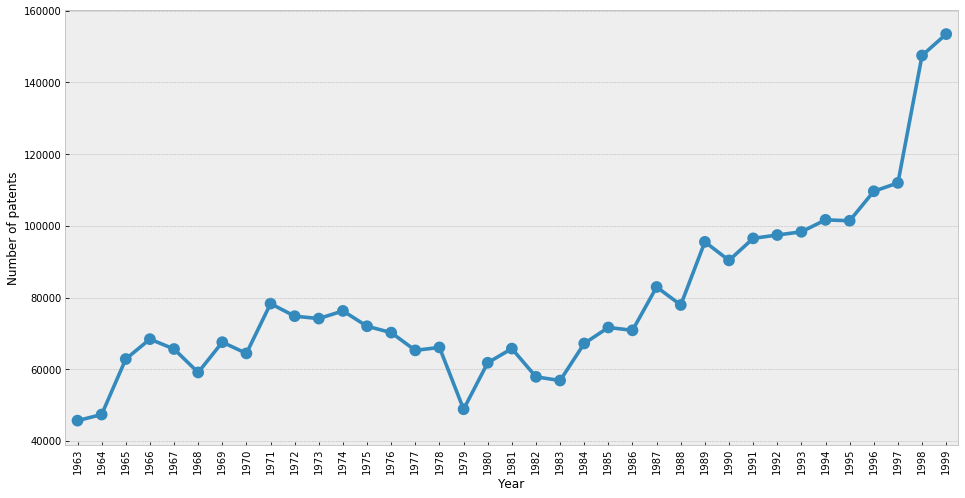

In [15]:
f, ax1 = plt.subplots(1, figsize=(16,8))
plt.xticks(rotation=90)
g=sbn.pointplot(x=year_trend.index, y='PATENT',  data=year_trend, ax=ax1)
g.set(xlabel='Year', ylabel='Number of patents')

We can see that the number of granted patents is constantly increasing through the years, except for the period from 1974-1983 when there was some decrease, probably caused by some events in the world.

* **Which countries have the most assigned patents?**

Will try to answer this question for patents from year 1998.

In [16]:
country_trend = df[['PATENT', 'COUNTRY', 'GYEAR']]
country_trend = country_trend[country_trend['GYEAR']==1998].drop('GYEAR', axis=1)
country_trend = country_trend.groupby('COUNTRY').count()
country_trend.head()

,PATENT
COUNTRY,
AD,2
AE,1
AI,1
AN,1
AR,43


In [17]:
country_trend2 = country_trend.merge(countries, left_index=True, right_on='Code').set_index('Code')
country_trend2.sort_values(by=['PATENT'], ascending=False).head(15)

,PATENT,Country
Code,,
US,80291,UNITED STATES
JP,30840,JAPAN
DE,9095,GERMANY
FR,3674,FRANCE
GB,3464,UNITED KINGDOM
KR,3259,SOUTH KOREA
TW,3100,TAIWAN
CA,2974,CANADA
IT,1584,ITALY


In [57]:
def popup_text(country_code):
    rate=int(country_trend2[country_trend2.index==country_code].PATENT)
    country=country_trend2[country_trend2.index==country_code].iloc[0]['Country']
        
    html = "<h5>" + country + " number of patents in 1998: " + "<br>"
    html += str(rate) + "</h5><br>"
    
    return html

In [60]:
world = [52, 18] 
m = folium.Map(location=world, tiles='cartodbpositron', zoom_start=2)

countries_geo_path = 'data/countries.geo.json'
geo_json_data = json.load(open(countries_geo_path))

def get_color(value):
    if value >=1 and value < 500:
        return '#fff0e6'
    elif value >= 500 and value < 1000:
        return '#ffc299'
    elif value >= 1000 and value < 5000:
        return '#ff751a'
    elif value >= 5000 and value < 10000:
        return '#993d00'
    elif value >= 10000:
        return '#1a0a00'
    
countries_map = []

for i in geo_json_data['features']:
    popup_html = popup_text(i['id'])
    popup = folium.Popup(html=popup_html, max_width=500)
    
    country_json=folium.GeoJson(
    i,
    style_function=lambda i: {
        'fillColor': get_color(patent_dict[i['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
    )
    country_json.add_child(popup)
    country_json.add_to(m)

In [61]:
m

*You can click on every country to see the exact number of patents.*

As expected, United States are in the first place with 80291 registered patents, and they even have more patents than all other countries together. In second place is Japan with 30840 patents and then is Germany with 9095 patents. From the results we can see that the patents are unevenly distributed, there are only three countries with more than 9000 patents, and only one country with more than 50000 registered patents. All other countries have less than 4000 registered patents during the year 1998.

* **What are the most popular technology fields for patents assigned in the last 5 years?**

In this section, we are interested in changes in number of patents in each technology field thorough the years. To answer this question, We only need pat63_99 dataset.

Our dataset contains in total 2923922 entries from 1963 to 1999. Thus let's group our dataset by years to find "time" dataframe which contains number of patents in each category thorough the these years.

In [4]:
#Finding all the unique year values to save time
years=np.sort(patent["GYEAR"].unique())
time=[]
for year in years:
    #for each dataframe section in given year
    current=patent[patent["GYEAR"]==year]
    #group dataframe by CAT field (CAT for technology category)
    numbers=current.groupby('CAT')['PATENT'].nunique()
    time.append(numbers)
#transform our dataset into dataframe for convenience
time=pd.DataFrame(time)
time["Time"]=years
time=time.set_index("Time")

Now let's see the results

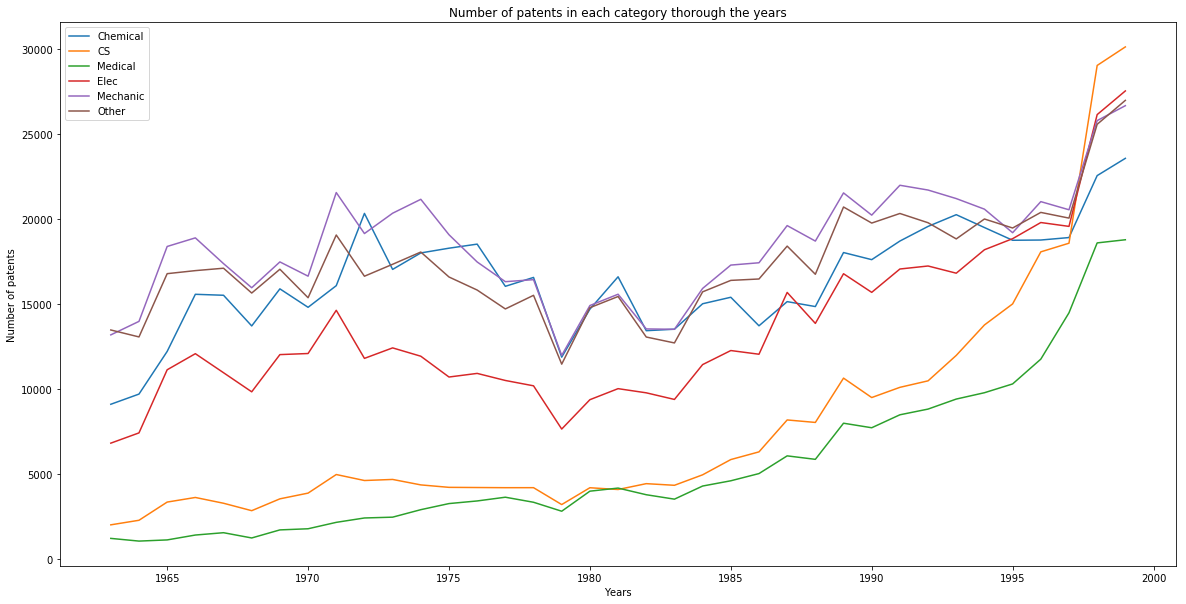

In [17]:
idxs=range(1,7)
#Category fields
names=["Chemical","CS","Medical","Elec","Mechanic","Other"]
plt.figure(figsize=(20,10))
for idx in idxs:
    plt.plot(years,time[idx],label=names[idx-1])
#Ornaments for graph
plt.legend(loc='upper left')
plt.title("Number of patents in each category thorough the years")
plt.ylabel("Number of patents")
plt.xlabel("Years")
plt.show()

So according to the graph above the most popular technology field from 1965 to 2000 was Mechanics. In general every technology field's line follow similar pattern except Computer Science and Medical Science, which increased dramatically over the 40 years. Interestengly, there is noticeable gap in 1979 in all fields. In general, we can say electronics and mechanics are popular fields but Computer science is the most trending field and have tendency to become the most popular field since 2000.

* **What's the most frequent technology field by inventor's country?**

In this section, we are interested in most frequent technology field by inventor's country. We can follow similar procedure as previous section, since we are interested in number of patents also. Let's create country dataframe which contains number of patents of each country. 

In [19]:
#Finding all the country IDs
countries=np.sort(patent["COUNTRY"].unique())
country=[]
for c in countries:
    current=patent[patent["COUNTRY"]==c]
    numbers=current.groupby('CAT')['PATENT'].nunique()
    country.append(numbers)
#Adding ornaments to the graph
country=pd.DataFrame(country)
country["Country"]=countries
country=country.set_index("Country")
country.head()

CAT,1,2,3,4,5,6
Country,,,,,,
AD,NaN,NaN,NaN,NaN,3.0,3.0
AE,2.0,1.0,NaN,1.0,NaN,14.0
AG,1.0,1.0,NaN,2.0,4.0,1.0
AI,NaN,NaN,NaN,NaN,NaN,1.0
AL,NaN,NaN,NaN,NaN,1.0,NaN


So since we have so many countries, It would be not very informative to analyze each countries. Thus let's describe our data and focus on 5 countries with highest number of patents in total 

In [20]:
#Describing the country
country.describe()

CAT,1,2,3,4,5,6
count,120.000000,90.000000,103.000000,116.000000,129.000000,131.000000
mean,5057.783333,3225.966667,1982.514563,4308.112069,5282.000000,4895.671756
std,33839.945880,19220.116358,13078.685864,28597.223763,36342.836344,38861.265088
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000
50%,11.500000,9.500000,14.000000,8.000000,12.000000,15.000000
75%,191.000000,120.500000,151.500000,139.250000,178.000000,127.500000
max,357198.000000,167941.000000,130840.000000,293168.000000,395215.000000,440627.000000


The data description indicates only few countries possess the highest number of inventors, which is solid assumption due to educational and research opportunities in developed countries.

In [41]:
#Ordering dataframe by total number of patents
ordered=country.fillna(0)
ordered["total"]=np.sum(ordered,axis=1)
ordered=ordered.sort_values("total",ascending=False)
ordered.head()

CAT,1,2,3,4,5,6,total
Country,,,,,,,
US,357198.0,167941.0,130840.0,293168.0,395215.0,440627.0,1784989.0
JP,81763.0,72934.0,19145.0,91655.0,105013.0,50931.0,421441.0
DE,61689.0,10306.0,13608.0,32986.0,62916.0,39590.0,221095.0
GB,21666.0,8083.0,8553.0,17149.0,23960.0,18601.0,98012.0
FR,18488.0,8017.0,7697.0,15889.0,20203.0,15104.0,85398.0


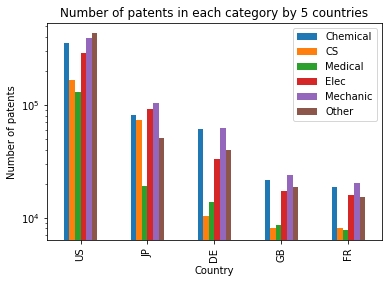

In [62]:
#Plotting first 5 ocuntries
interested=ordered.head()
interested=interested.drop(['total'], axis=1)
interested.columns = names
interested.plot(kind='bar',logy=True)
plt.title("Number of patents in each category by 5 countries")
plt.ylabel("Number of patents")
plt.show()

The graph above shows interesting relation, which is computer science inventors from US and Japan are much more higher than that of other countries. And also, these 2 countries have more inventors than any other countries. Other than that this bar plot shows similar trend with previos section's results.

* **What percentage of patents belongs to privates and what to organizations?**

Here we found out that the dataset is even more accurate as there are several assignee types in the column "ASSCODE":

    1 = unassigned
    2 = assigned to a U.S. nongovernment organization
    3 = assigned to a non-U.S., nongovernment organization
    4 = assigned to a U.S. individual
    5 = assigned to a non-U.S. individual
    6 = assigned to the U.S. (Federal) Government
    7 = assigned to a non-U.S. government

In [36]:
assignee = df[['PATENT', 'ASSCODE']]
assignee = assignee.groupby('ASSCODE').count()
assignee

,PATENT
ASSCODE,
1,537988
2,1380310
3,913470
4,24097
5,9146
6,48323
7,10588


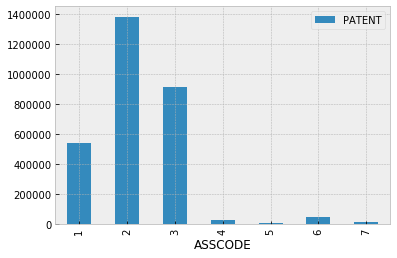

In [23]:
assignee.plot.bar()

In [33]:
(assignee.loc[2]+assignee.loc[3])/assignee.sum()*100

PATENT    78.448741
dtype: float64

78.4% of the patents belong to nongovernment organizations

In [34]:
(assignee.loc[4]+assignee.loc[5])/assignee.sum()*100

PATENT    1.136932
dtype: float64

1.1% of the patents belong to privates

In [35]:
(assignee.loc[6]+assignee.loc[7])/assignee.sum()*100

PATENT    2.014794
dtype: float64

2.0% of the patents belong to governments all over the world

## Patent citations

One part of this dataset is a network(graph) dataset, so will focus now a little bit on it. We will try to analyse patent citations and answer some questions. 

First let's try to visualize the dataset. Because the graph dataset is too large with more then 3 million nodes and more then 16 million edges, we will show just one small part of it. 

In [178]:
citations = pd.read_csv('data/cit-Patents.txt', sep='\t', skiprows=[0,1,2])
citations.head()

,# FromNodeId,ToNodeId
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


In [179]:
df = pd.read_csv('data/apat63_99.csv')[['PATENT', 'GYEAR', 'COUNTRY']]
df.head()

,PATENT,GYEAR,COUNTRY
0,3070801,1963,BE
1,3070802,1963,US
2,3070803,1963,US
3,3070804,1963,US
4,3070805,1963,US


In [180]:
citations_year_ch = citations.merge(df, left_on='# FromNodeId', right_on='PATENT').merge(df, left_on='ToNodeId', right_on='PATENT')
citations_year_ch = citations_year_ch[(citations_year_ch['COUNTRY_x']=='US') & (citations_year_ch['COUNTRY_y']=='CH')]
citations_year_ch = citations_year_ch[(citations_year_ch['GYEAR_y']==1998)]
citations_year_ch.head()

,# FromNodeId,ToNodeId,PATENT_x,GYEAR_x,COUNTRY_x,PATENT_y,GYEAR_y,COUNTRY_y
11403126,5922473,5767169,5922473,1999,US,5767169,1998,CH
11403127,5925402,5767169,5925402,1999,US,5767169,1998,CH
11403128,6005017,5767169,6005017,1999,US,5767169,1998,CH
13657168,5937786,5713301,5937786,1999,US,5713301,1998,CH
13725636,5828493,5760981,5828493,1998,US,5760981,1998,CH


In [181]:
G = nx.Graph()

for i, row in citations_year_ch.iterrows():
        G.add_edge(row['# FromNodeId'], row['ToNodeId'])

In [192]:
pos = nx.random_layout(G)

In [193]:
edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    edge_trace['x'] += [pos[edge[0]][0],pos[edge[1]][0], None]
    edge_trace['y'] += [pos[edge[0]][1],pos[edge[1]][1], None] 

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Number of citations',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for nd in G.nodes():
    node_trace['x'].append(pos[nd][0])
    node_trace['y'].append(pos[nd][1])

In [194]:
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of citations: '+str(len(adjacencies))
    node_trace['text'].append(node_info)

In [195]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Swiss patents from 1998 cited by US patents',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))
config={'showLink': False}

The next graph is showing Swiss patents from year 1998 which are cited by patents granted in United States.

In [196]:
py.iplot(fig, filename='networkx', config=config)